# PCA Feature Evaluation

This notebook evaluates the usefulness of graph-based features using Principal Component Analysis (PCA).

## Import libraries and load data

Imports required libraries for data manipulation, graph analysis, and scaling. Loads the training and test datasets.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import ast
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Define centrality and preprocessing functions

Defines functions to compute graph centrality features, expand the dataset, and normalize features by sentence.

In [2]:
def centralities(edgelist):
    """Calculate centrality measures for graph nodes."""
    if not edgelist:
        return {}
    
    T = nx.from_edgelist(edgelist)
    
    degree = nx.degree_centrality(T)
    closeness = nx.closeness_centrality(T)
    betweenness = nx.betweenness_centrality(T)
    eccentricity = nx.eccentricity(T)
    leaf_node = [v for v, d in T.degree() if d == 1]
    farness = {v: 1 / (eccentricity[v] + 1) for v in T.nodes() if eccentricity[v] > 0}
    
    # Calculate subtree heights
    subtree_height = {}
    for node in T.nodes():
        distances = nx.single_source_shortest_path_length(T, node)
        subtree_height[node] = max(distances.values()) if distances else 0

    features = {}
    for v in T:
        features[v] = (
            degree[v], closeness[v], betweenness[v], eccentricity[v],
            leaf_node.count(v), farness[v], subtree_height[v]
        )
    return features

def data_preparation_train(data):
    expanded_set = []

    for index, row in data.iterrows():
        edgelist = ast.literal_eval(row['edgelist'])
        central_edges = centralities(edgelist)
        language = row['language']
        sentence = row['sentence']
        n = row['n']
        root = row['root'] 
        for vertex, values in central_edges.items():
            expanded_set.append((language, sentence, n, vertex, *values, vertex == root))

    return expanded_set


def normalize_features_by_sentence(data, feature_columns, group_col='sentence'):
    grouped = data.groupby(group_col)
    normalized_groups = []
    scalers = {}

    for name, group in grouped:
        scaler = MinMaxScaler()
        numeric_features = group[feature_columns].select_dtypes(include=np.number).columns
        normalized = scaler.fit_transform(group[numeric_features])
        scalers[name] = scaler

        normalized_df = pd.DataFrame(normalized, columns=numeric_features, index=group.index)
        combined = group.drop(columns=numeric_features).join(normalized_df)
        normalized_groups.append(combined)

    normalized_data = pd.concat(normalized_groups).sort_index()
    return normalized_data, scalers



## Expand training data with centrality features

Expands the training data by computing centrality features for each node in each graph and stores the result in a DataFrame.

In [3]:
expanded_data = pd.DataFrame(data_preparation_train(train), columns=['language', 'sentence', 'n', 'vertex', 
    'degree', 'closeness', 'betweenness', 'eccentricity','leaf_node', 'farness', 'subtree_height',
                                                    'is_root'])

## PCA

Imports PCA and plotting libraries, defines the feature columns, and provides functions to perform PCA and visualize the results.

In [4]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

feature_columns = [
    'degree', 'closeness', 'betweenness', 'eccentricity','leaf_node', 'farness', 'subtree_height'
]

def perform_pca(data, target):
    
    normalized_data, scalers = normalize_features_by_sentence(data, feature_columns,['language', 'sentence'])
    X_train_final = normalized_data[feature_columns]


    # Perform PCA
    pca = PCA()
    pca_result = pca.fit_transform(X_train_final)

    # Create a DataFrame for PCA results
    pca_df = pd.DataFrame(
        data=pca_result,
        columns=[f'PC{i+1}' for i in range(pca_result.shape[1])]
    )

    # Extract explained variance ratio and PCA components
    explained_variance = pca.explained_variance_ratio_
    components = pca.components_

    # Reshape target_data to a 2D array (n_samples, 1)
    target_data_reshaped = target.values.reshape(-1, 1)

    # Compute the correlation between target_data and each principal component
    correlation_target = np.array([np.corrcoef(target_data_reshaped.T, pca_result[:, i])[0, 1] for i in range(pca_result.shape[1])])

    # Visualize explained variance
    plt.figure(figsize=(10, 6))
    sns.barplot(x=[f'PC{i+1}' for i in range(len(explained_variance))], y=explained_variance)
    plt.title('Explained Variance Ratio by Principal Component')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.show()

    return pca_df, {"explained_variance": explained_variance, "components": components}, correlation_target

def plot_corrplot(pca_metadata, numerical_data, target_correlation):
    # Extract PCA components
    components = pca_metadata["components"]
    
    # Create a DataFrame for the correlation between original variables and PCs
    corr_df = pd.DataFrame(
        data=components.T,  # Transpose so rows represent original variables
        index=numerical_data.columns,
        columns=[f'PC{i+1}' for i in range(components.shape[0])]
    )
    
    # Add target correlation as a separate row
    target_corr_df = pd.DataFrame(
        data=[target_correlation],
        index=['Target Correlation'],
        columns=[f'PC{i+1}' for i in range(len(target_correlation))]
    )
    
    # Combine the two DataFrames
    combined_corr_df = pd.concat([corr_df, target_corr_df])
    
    # Plot the heatmap using seaborn
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        combined_corr_df,
        annot=True,
        cmap='coolwarm',
        fmt=".2f",
        square=True,
        cbar_kws={'label': 'Correlation Coefficient'}
    )
    plt.title('Correlation Between Original Variables and Principal Components')
    plt.xlabel('Principal Components')
    plt.ylabel('Features / Target')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()


## Run PCA and plot correlations

Performs PCA on the expanded and normalized feature set, then visualizes the correlation between original features, principal components, and the target variable.

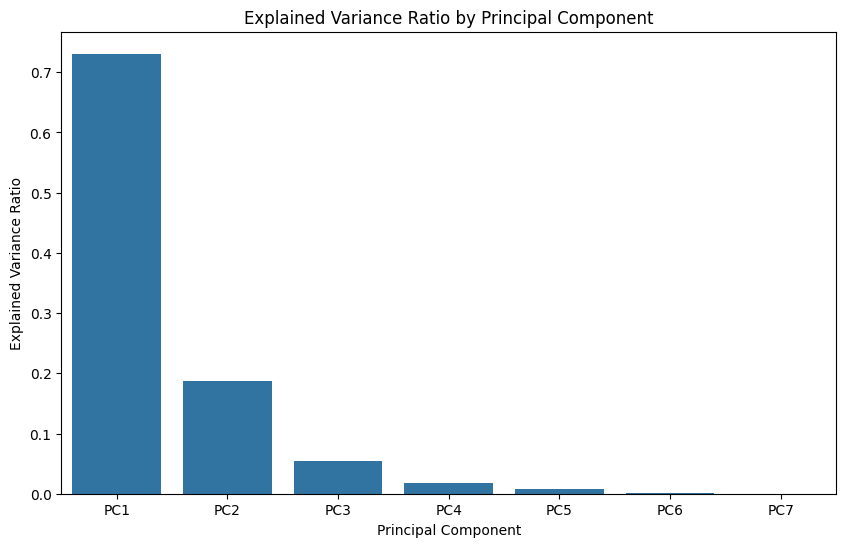

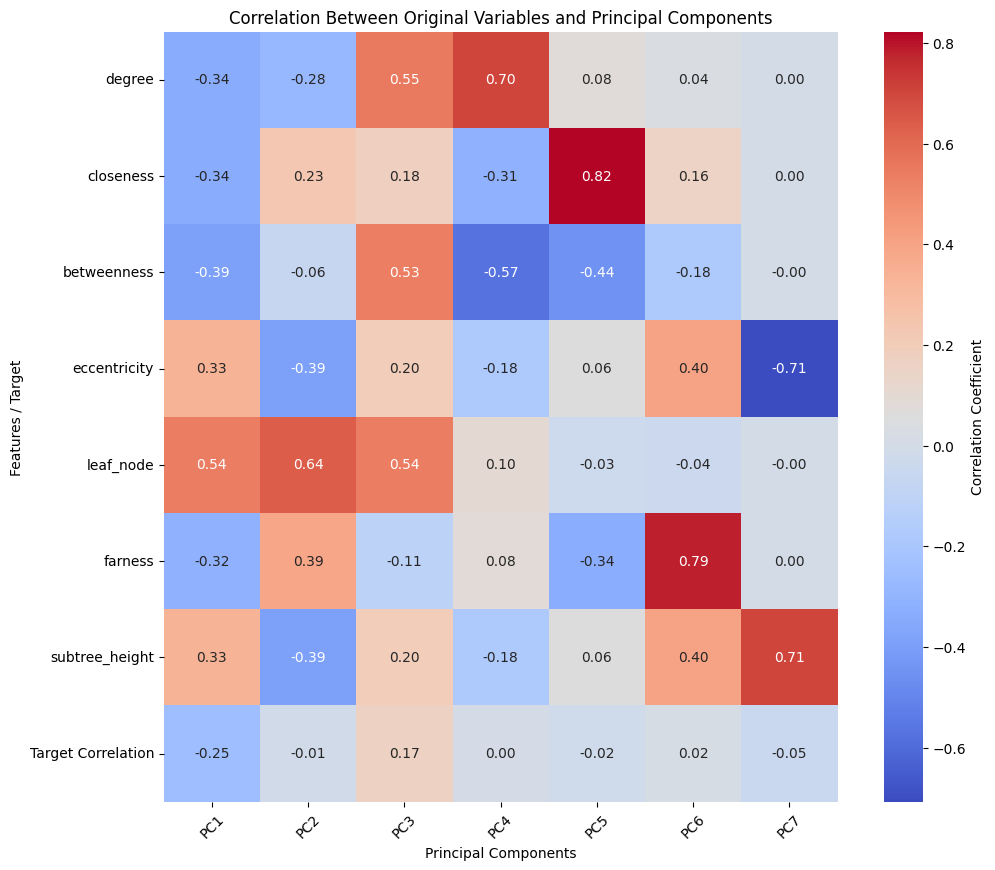

In [5]:
# Function to calculate centrality measures and subtree heights
pca_df, pca_dic, cor = perform_pca(expanded_data, expanded_data['is_root'])

# Plot correlation heatmap
plot_corrplot(pca_dic, expanded_data[['degree', 'closeness', 'betweenness', 'eccentricity','leaf_node', 'farness', 'subtree_height']], cor)